In [1]:
import sys
sys.path.append('../src/')
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from corpus import Corpus
from models import GTM
from random import random
from simulations import generate_documents

# ----- Simulate data -----

df_true_dist, df, topic_words, true_lambda, true_label_coeff = generate_documents(
    num_docs=10000,
    num_topics=2,
    vocab_size=500,
    num_covs=0,
    num_languages=2,
    doc_topic_prior='logistic_normal',
    min_words=100,
    max_words=100,
    random_seed=42
)

# ----- Corpus + GTM -----
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_lang1 = CountVectorizer()
vectorizer_lang1.fit(df["doc_clean_0"]) 

vectorizer_lang2 = CountVectorizer()
vectorizer_lang2.fit(df["doc_clean_1"]) 

modalities = {
    "lang1": {
        "column": "doc_clean_0",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer_lang1
            }
        }
    },
    "lang2": {
        "column": "doc_clean_1",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer_lang2
            }
        }
    }
}

train_dataset = Corpus(df, modalities=modalities)

encoder_args = {
    "lang1_bow": {
        "hidden_dims": [128,64],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    },
    "lang2_bow": {
        "hidden_dims": [128,64],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

decoder_args = {
    "lang1_bow": {
        "hidden_dims": [64,128],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    },
    "lang2_bow": {
        "hidden_dims": [64,128],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

tm = GTM(
    train_data=train_dataset,
    n_topics=2,
    doc_topic_prior="logistic_normal",
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    print_every_n_epochs=10
)


Stopping at Epoch 7. Reverting to Epoch 6


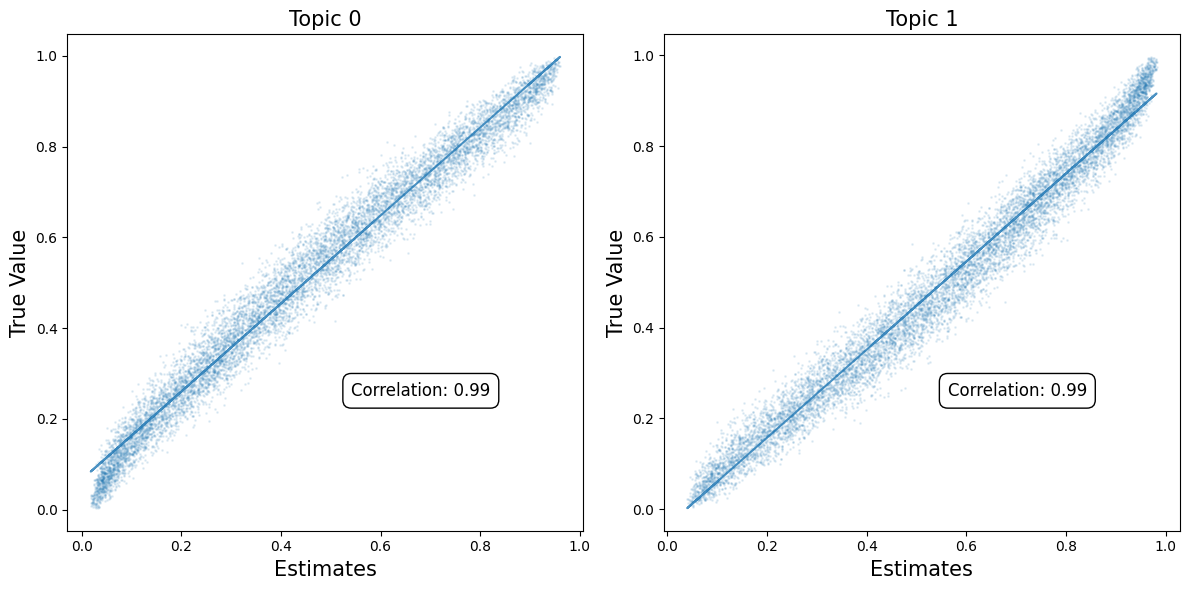

In [2]:
estimated_doc_topics = tm.get_doc_topic_distribution(train_dataset, num_samples=30)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):  
    x = estimated_doc_topics[:, i]  
    y = df_true_dist['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, s=1, alpha=0.1)
    
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), alpha=0.8)
    
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title(f'Topic {i}', fontsize=15)

    corr_coeff = np.corrcoef(x, y)[0, 1]
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                    fontsize=12, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

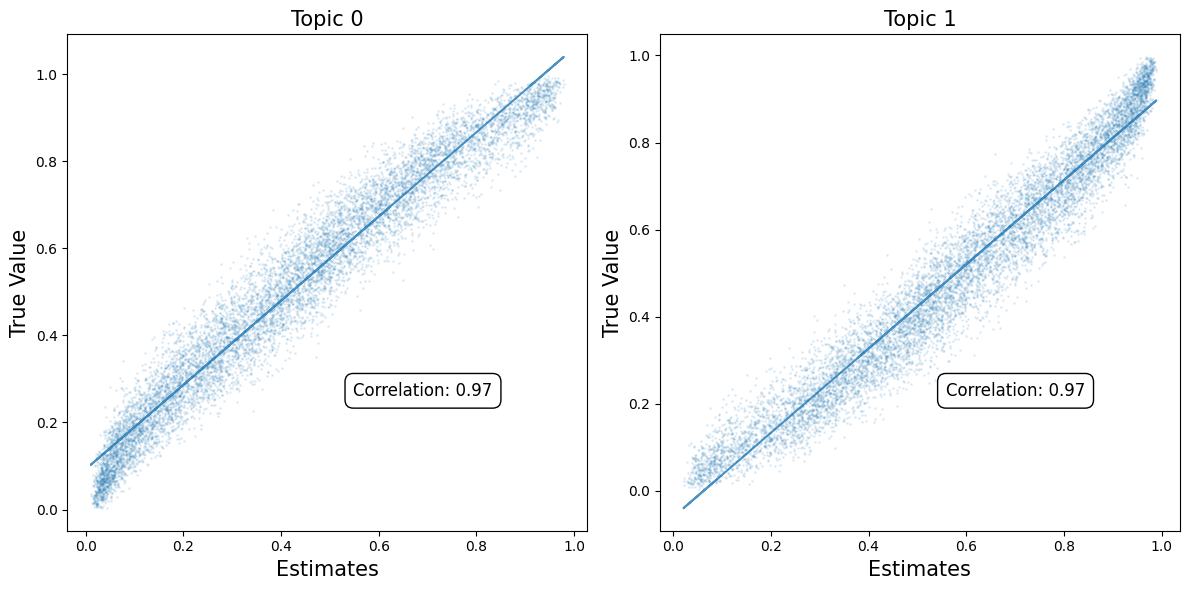

In [3]:
estimated_doc_topics = tm.get_doc_topic_distribution(train_dataset, single_modality="lang1_bow", num_samples=30)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):  
    x = estimated_doc_topics[:, i]  # or 1 - estimated_doc_topics[:, i] if that's your intention
    y = df_true_dist['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, s=1, alpha=0.1)
    
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), alpha=0.8)
    
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title(f'Topic {i}', fontsize=15)

    corr_coeff = np.corrcoef(x, y)[0, 1]
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                    fontsize=12, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()